# <center><font color='blue'>Use Case - Predictive Model to Identify Customers Likely to Take a Loan</font></center>
#### <center><font color='blue'>Author: Shyam Mohan Kizhakekara     |     Email Id: shyammohan.kizhakekara@boi.com</font></center>

In [158]:
# Import the required libraries
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## <font color='blue'>Config</font>

In [159]:
PROCESSED_DATA_DIR = "../data/processed/"
PROCESSED_TRAIN_DATA_DIR = PROCESSED_DATA_DIR + "train/"
PROCESSED_TEST_DATA_DIR = PROCESSED_DATA_DIR + "test/"
PROC_TRAINING_DATA_FILE = PROCESSED_TRAIN_DATA_DIR + "Processed_Training_Data.csv"
PROC_TEST_DATA_FILE = PROCESSED_TEST_DATA_DIR + "Processed_Testing_Data.csv"
ENCODING_FORMAT = "ISO-8859-1"
INTEGER_VAR_COL_LIST = ['Age', 'NoOfProductsHeld', 'NoOfTxns']
FLOAT_VAR_COL_LIST = ['LastTxnAmt', 'AvgTxnAmt']
CATEGORY_VAR_COL_LIST = ['Gender', 'County', 'LoanHeldBefore', 'MerCategory', 'IncomeCategory']
EDA_PARENT_DIR = "../eda/"
PREDICTED_DATA_DIR = "../data/predicted/"
PRE_LOAN_LIKELIHOOD_FILE = PREDICTED_DATA_DIR + "Predicted_Loan_Likelihoods.csv"

## <font color='blue'>Data Load</font>

In [160]:
def restore_valid_col_dtypes(df_loan_data):
    """
    Method to restore the column dtypes in the pandas dataframe (as they were converted to 'str' earlier).
    :param df_loan_data: A pandas dataframe object containing the data merged from the CSV files.
    :return A pandas dataframe object containing all the required columns in cleaned format.
    """
    df_col_list = df_loan_data.columns
    for col in INTEGER_VAR_COL_LIST:
        df_loan_data[col] = df_loan_data[col].astype(int)

    for col in FLOAT_VAR_COL_LIST:
        df_loan_data[col] = df_loan_data[col].astype(float)

    for col in CATEGORY_VAR_COL_LIST:
        if col in df_col_list:
            df_loan_data[col] = df_loan_data[col].astype(object)
    return df_loan_data


def load_data_to_df(data_file_name):
    """
    Method to read the CSV file and load the data into a pandas dataframe.
    :param data_file_name: Name of the CSV file which contains the data.
    :return: A pandas dataframe object
    """
    input_data = restore_valid_col_dtypes(pd.read_csv(data_file_name, encoding=ENCODING_FORMAT))
    return input_data

<b>During the first level of pre-processing, we had loaded the data from every CSV file into a separate data frame, processed them individually and then combined them into a unified data frame based on the common column <font color='blue'>Client ID</font>.<br>We repeated the same set of operations on the Training and Testing data, and had written them into separate CSV files. We will now load the data from these newly generated CSV files.</b>

In [161]:
# Load the Training & Testing Data
df_cleaned_training_data = load_data_to_df(PROC_TRAINING_DATA_FILE)
df_cleaned_testing_data = load_data_to_df(PROC_TEST_DATA_FILE)

In [162]:
df_cleaned_training_data.shape

(10000, 12)

In [163]:
df_cleaned_training_data.head()

,ClientID,Age,Gender,County,LoanHeldBefore,NoOfProductsHeld,AvgTxnAmt,NoOfTxns,LastTxnAmt,LoanFlag,IncomeCategory,MerCategory
0,1,36,1,Cork,1,4,58.0,0,NaN,0,Lower Middle,Unknown
1,2,43,1,Cavan,0,4,2663.0,17,83.66,0,Low,Professional Services
2,3,32,0,Dublin,0,2,46.0,25,526.18,0,Lower Middle,Accommodation
3,4,52,1,Louth,1,2,0.0,13,70.68,0,Upper,Hardware
4,5,63,0,Kilkenny,0,1,126.0,39,259.07,0,Upper Middle,Retail


In [164]:
df_cleaned_training_data.dtypes

ClientID              int64
Age                   int64
Gender               object
County               object
LoanHeldBefore       object
NoOfProductsHeld      int64
AvgTxnAmt           float64
NoOfTxns              int64
LastTxnAmt          float64
LoanFlag              int64
IncomeCategory       object
MerCategory          object
dtype: object

In [165]:
df_cleaned_testing_data.shape

(2000, 11)

In [166]:
df_cleaned_testing_data.head()

,ClientID,Age,Gender,County,LoanHeldBefore,NoOfProductsHeld,AvgTxnAmt,NoOfTxns,LastTxnAmt,IncomeCategory,MerCategory
0,10001,59,1,Cork,0,4,22.0,2,12.59,Lower Middle,Professional Services
1,10002,27,1,Kerry,0,4,11.0,0,30.00,Lower Middle,Transport
2,10003,58,0,Louth,0,2,9.0,28,1003.01,Lower Middle,Hardware
3,10004,45,1,Dublin,0,2,34.0,31,873.25,Upper Middle,Accommodation
4,10005,21,0,Dublin,0,1,38.0,12,926.75,Upper,Accommodation


In [167]:
df_cleaned_training_data.columns

Index(['ClientID', 'Age', 'Gender', 'County', 'LoanHeldBefore',
       'NoOfProductsHeld', 'AvgTxnAmt', 'NoOfTxns', 'LastTxnAmt', 'LoanFlag',
       'IncomeCategory', 'MerCategory'],
      dtype='object')

In [168]:
df_cleaned_testing_data.columns

Index(['ClientID', 'Age', 'Gender', 'County', 'LoanHeldBefore',
       'NoOfProductsHeld', 'AvgTxnAmt', 'NoOfTxns', 'LastTxnAmt',
       'IncomeCategory', 'MerCategory'],
      dtype='object')

<b>Some of the key highlights at this stage:
 - There are <font color='blue'>10000 observations</font> in our Training set, described by <font color='blue'>12 data points/features</font>.
 - There are <font color='blue'>2000 observations</font> in our Testing set, described by <font color='blue'>11 data points/features</font>.
 - The columns in our Training and Testing sets are the same, except for the extra column <font color='blue'>'LoanFlag'</font> in our Training set which <font color='blue'>is our target variable</font>.</b>

## <font color='blue'>Exploratory Data Analysis</font>

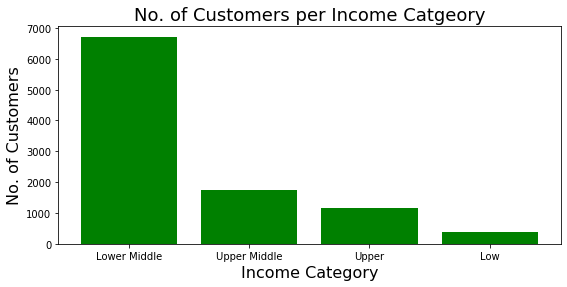

In [169]:
new_df = pd.DataFrame(df_cleaned_training_data['IncomeCategory'].value_counts())
# Import the required libraries to plot the graphs
import matplotlib, pylab
import matplotlib.pyplot as plt
%matplotlib inline

# Set the corresponding positions on the y-axis
y_pos = range(len(new_df.index.values))

# Create a new figure & set the canvas size
plt.figure(figsize=(9,4))

# Plot the bar chart
bars = plt.bar(y_pos, new_df['IncomeCategory'], align='center', color='green')
plt.xticks(y_pos, new_df.index.values)
plt.xlabel("Income Category", fontsize=16)
plt.ylabel("No. of Customers", fontsize=16)
plt.title("No. of Customers per Income Catgeory", fontsize=18)
plt.savefig(EDA_PARENT_DIR + 'Customers_per_IncomeCategory.png')

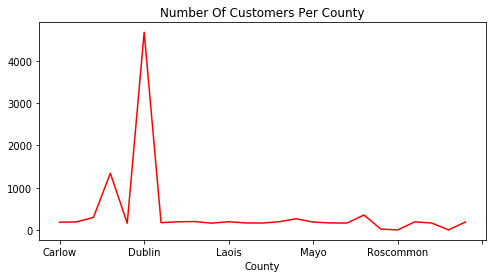

In [170]:
df_county = df_cleaned_training_data[['ClientID', 'County']].copy()
df_county = df_county.groupby('County').count()
fig = df_county["ClientID"].plot(title="Number Of Customers Per County", figsize=(8,4), color='red').get_figure()
fig.savefig(EDA_PARENT_DIR + 'Customers_per_County.png')

## <font color='green'>Part 1 - Business Intelligence</font>

<b><font color='blue'>1. How Many Customers above 50 years old have taken up a loan?</font></b>

In [171]:
df_cleaned_training_data[(df_cleaned_training_data.Age > 50) & (df_cleaned_training_data.LoanFlag == 1)].shape[0]

98

<b><font color='blue'>2. How Many Females aged 30 to 40 have more than 2 products?</font></b>

In [172]:
df_cleaned_training_data[(df_cleaned_training_data.Gender == 0) & (df_cleaned_training_data.Age >= 30) & \
                         (df_cleaned_training_data.Age <= 40) & (df_cleaned_training_data.NoOfProductsHeld > 2)].shape[0]

622

<b><font color='blue'>3. What is the average number of Current Account (CA) Transactions for males who had previous Loans?</font></b>

<b>The obtained mean value is rounded up to the nearest integer not smaller than the actual value, using the ceil function.</b>

In [173]:
df_males_with_previous_loans = df_cleaned_training_data[(df_cleaned_training_data.Gender == 1) & \
                                                        (df_cleaned_training_data.LoanHeldBefore == 1)]
math.ceil(df_males_with_previous_loans['NoOfTxns'].mean())

19

<b><font color='blue'>4. How many females did not have previous loans and who are aged:
- Less than 20
- 21 to 40
- 40+
</font></b>

In [174]:
df_females_without_previous_loans = df_cleaned_training_data[(df_cleaned_training_data.Gender == 0) & \
                                                             (df_cleaned_training_data.LoanHeldBefore == 0)]
print("Age less than 20:", df_females_without_previous_loans[(df_females_without_previous_loans.Age < 20)].shape[0])
print("Age between 21 and 40:", df_females_without_previous_loans[(df_females_without_previous_loans.Age >= 21) & \
                                                                  (df_females_without_previous_loans.Age <= 40)].shape[0])
print("Age above 40:", df_females_without_previous_loans[(df_females_without_previous_loans.Age > 40)].shape[0])

Age less than 20: 0
Age between 21 and 40: 1534
Age above 40: 2003


## <font color='green'>Part 2 - Predictive Modelling</font>

### <font color='red'>2.1. Optimizing the Problem Statement</font>

<b>We consider the target variable representation as follows:<br>
    <font color='blue'>0</font> - Target variable representing the Customers who <font color='blue'>Did Not Avail a Loan</font><br> <font color='blue'>1</font> - Target variable representing the Customers who <font color='blue'>Availed a Loan.</font><br><br>
This helps us infer that we have a <font color='blue'>Binary Classification</font> problem at hand.
</b>

In [175]:
# Values of the target variable - Identiying Class Labels
df_cleaned_training_data.LoanFlag.unique()

array([0, 1])

### <font color='red'>2.2. Dropping Irrelvant Columns & Rows</font>
<b>We start by eliminating all those columns and rows in our dataframe, that either do not add any value to our predictions or might be noise in the data. We would also drop the columns that contain extensively high null values or unique values.</b>

In [176]:
def drop_noise_data(df_loan_data):
    # Drop the ID column, as it is not required for predictions
    df_loan_data.drop(['ClientID'], axis = 1, inplace = True)
    
    # Any observation with County value "Outside ROI" can be dropped off, as our focus is on ROI
    df_loan_data.drop(df_loan_data[df_loan_data['County'] == "Outside ROI"].index, inplace=True)
    
    # Drop observations for which LoanHeldBefore value is unknown (-1)
    df_loan_data.drop(df_loan_data[df_loan_data['LoanHeldBefore'] == -1].index, inplace=True)
    
    return df_loan_data

In [177]:
df_cleaned_training_data = drop_noise_data(df_cleaned_training_data)

<b>Since we also have our testing set ready, we store the ID column separately for future use.</b>

In [178]:
test_data_id_list = df_cleaned_testing_data['ClientID'].tolist()
df_cleaned_testing_data = drop_noise_data(df_cleaned_testing_data)

### <font color='red'>2.3. Balancing Target Classes</font>
<b>A major step before building the predictive model is balancing the classes (target variables). We can see below that the number of observations with the class label <font color='blue'><i>0</i></font> are much more than the number of observations with the class label <font color='blue'><i>1</i></font>. This implies that the problem of <font color='blue'><i>class imbalance</i></font> exists in our training set.</b>

In [179]:
df_cleaned_training_data.LoanFlag.value_counts()

0    9764
1     211
Name: LoanFlag, dtype: int64

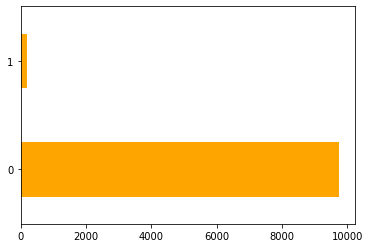

In [180]:
# Check for class imbalance
df_cleaned_training_data.LoanFlag.value_counts().plot.barh(color='orange')

<b>Imbalanced data typically refers to a situation in classification problems, where the target classes are not represented equally in a dataset. In such cases, the output of the classification model would be biased and most often, the model always ends up predicting the majority class.<br>To handle this, some of the best possible approaches used are <font color='blue'>undersampling the majority class</font> or <font color='blue'>oversampling the minority class</font>.<br><br>In our case, we will proceed by oversampling the minority class, mainly because undersampling the majority class there is extensive data loss which would leave us with very few observations to train the model.<b>

In [181]:
# Separate majority and minority classes
majority_class_data = df_cleaned_training_data[df_cleaned_training_data.LoanFlag==0]
minority_class_data = df_cleaned_training_data[df_cleaned_training_data.LoanFlag==1]
 
# Oversample minority class
minority_class_data_upsampled = resample(minority_class_data, 
                                 replace=True,     # sample with replacement
                                 n_samples=majority_class_data.shape[0],    # match majority class
                                 random_state=123)
 
# Combine majority class with upsampled minority class
balanced_loan_dataset = pd.concat([majority_class_data, minority_class_data_upsampled])
 
# Display new class counts
balanced_loan_dataset.LoanFlag.value_counts()

1    9764
0    9764
Name: LoanFlag, dtype: int64

### <font color='red'>2.4. Data Split - Training & Validation Sets</font>
<b>Next, we split out training data into training and validations sets. We use a 75-25 split here, i.e., 75% of the data for Training and 25% for Validation.</b>

In [182]:
X = balanced_loan_dataset.drop('LoanFlag', axis=1)
y = balanced_loan_dataset['LoanFlag']

In [183]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

### <font color='red'>2.5. Data Preprocessing Pipeline</font>
<b>Here, we define the data steps for pre-processing our data.<br>
- For numerical variables we use replace the mising values with the <font color='blue'><i>mean</i></font> of the column.
- For categorical variables, we fill the value <font color='blue'><i>Unknown</i></font> for any missing values.</b>

In [184]:
# As the first step, we separate the numerical and categorical features into two lists.
numeric_features = balanced_loan_dataset.select_dtypes(include=['int64', 'float64']).drop(['LoanFlag'], 
                                                                                          axis=1).columns
categorical_features = balanced_loan_dataset.select_dtypes(include=['object']).columns

In [185]:
# Build the inidvidual pieplines for each set of features
num_col_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), 
                                          ('scaler', MinMaxScaler())])
categ_col_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), 
                                              ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [186]:
# Get the ColumnTransformer object to apply the transformation steps to the columns/features
loan_data_preprocessor = ColumnTransformer(transformers=[('num', num_col_transformer, numeric_features), 
                                          ('cat', categ_col_transformer, categorical_features)])

### <font color='red'>2.6. Feature Selection</font>
<b><font color='blue'>Curse of dimensionality</font> is a phenomenon which causes different machine learning algorithms to perform with poor accuracy levels on high-dimensional data. It is extrememly important to select the best features that would contribute well to our prediction models. If not done, it could lead to overfitting and also increase the costs of computation. We use <font color='blue'><i>RandomForestClassifier</font></i> to get the best features.</b>

In [187]:
loan_data_feature_selector = SelectFromModel(RandomForestClassifier(n_estimators = 200))

### <font color='red'>2.7. Model Selection</font>
<b>Ideally in this step, we create a list of a varierty of Classification algorithms which, in theory, would suit our data best. We then compare the performance of the models using different metrics, revisit our data and finalize the algorithm to build our model.<br>However, this step requires considerable amount of time and compute power to yield good results. Based on extensive reading and literature survey, I figured out that <font color='blue'>Logistic Regression</font> is one of the most common methods used for building propensity models. As such, I have used the same to build my model.</b>

In [188]:
# Build a simple classifier using the default parameters
loan_data_classifer = LogisticRegression()
loan_data_classifer

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### <font color='red'>2.8. Data Pipeline</font>
<b>Now, we build the data pipeline which would help us apply all the required steps (Pre-processing, Feature Selection and Prediction) sequentially on our data.</b>

In [189]:
loan_data_pipeline = Pipeline(steps=[('preprocessor', loan_data_preprocessor), 
                                     ('feat_select', loan_data_feature_selector), 
                                     ('classifier', loan_data_classifer)])

### <font color='red'>2.9. Cross Validation</font>
<b>We first use the data pipeline to fit our training data and preidct the outcomes on our validation set. This would give us the initial accuracy score.</b>

In [190]:
loan_data_pipeline.fit(X_train, y_train)
y_pred = loan_data_pipeline.predict(X_val)
model_accuracy_score = round(accuracy_score(y_val, y_pred)*100, 3)
print("Model Accuracy before Cross Validation: ", model_accuracy_score, "%")

Model Accuracy before Cross Validation:  96.057 %


/Users/shyammk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<b>However, it is important that we perform cross validation to avoid overfitting and test the generalizability of the model. We use the k-fold cross validation technique, with k=10, and calculate the mean accuracy score.</b>

In [191]:
mean_model_accuracy_score = round((np.mean((cross_val_score(loan_data_pipeline, X, y, cv=10)) * 100)), 3)

/Users/shyammk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shyammk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shyammk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shyammk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shyammk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

In [192]:
print("Model Accuracy after Cross Validation: ", mean_model_accuracy_score, "%")

Model Accuracy after Cross Validation:  96.185 %


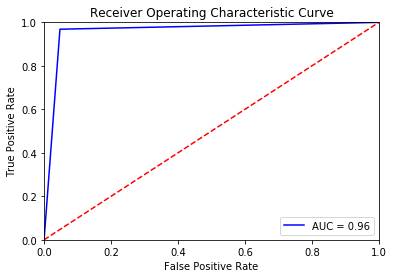

In [193]:
# Calculate the False Positive Rate and True Positive Rate
fp_rate, tp_rate, threshold = metrics.roc_curve(y_val, y_pred)
auc_value = metrics.auc(fp_rate, tp_rate)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic Curve')
plt.plot(fp_rate, tp_rate, 'b', label = 'AUC = %0.2f' % auc_value)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### <font color='red'>2.10. Performance Tuning</font>
<b>Machine learning models are parameterized so that their behavior can be tuned for a given problem. Here, using <font color='blue'><i>Exhaustive Grid Search</i></font>, we find the fine-tuned parameters for each classifier model being built. It is an approach to parameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid.</b>

In [194]:
# Function to return the fine-tuned parameters for the classifier
def get_tuned_classifier(classifier_model, parameter_grid):
    grid_search_classifier = GridSearchCV(classifier_model, parameter_grid, scoring='accuracy', verbose=1000, cv=10)
    grid_search_classifier = grid_search_classifier.fit(X_train, y_train)
    return grid_search_classifier

In [195]:
parameter_grid = {'classifier__penalty': ['l1', 'l2'], 
                  'classifier__C': [0.01, 0.1, 1], 
                  'classifier__solver': ['liblinear']}
tuned_loan_data_pipeline = get_tuned_classifier(loan_data_pipeline, parameter_grid)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear 
[CV]  classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear, score=0.959, total=   5.5s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s
[CV] classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear 
[CV]  classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear, score=0.949, total=   5.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
[CV] classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear 
[CV]  classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear, score=0.955, total=   8.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.1s remaining:    0.0s
[CV] classifier__C=0.01, classifier__penalty=l1, classifier_

[CV]  classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, score=0.951, total=   4.9s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  4.2min remaining:    0.0s
[CV] classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear 
[CV]  classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, score=0.959, total=   4.8s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  4.2min remaining:    0.0s
[CV] classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear 
[CV]  classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, score=0.966, total=   5.2s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  4.3min remaining:    0.0s
[CV] classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear 
[CV]  classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, score=0.965, total=   5.1s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  4.4min remaining:    0.0s
[CV] classifier__C=0.1

### <font color='red'>2.11. Test Data Prediction</font>
<b>Now that we have a high performing model, let us predict the loan likelihoods for each observation in our test data.</b>

In [196]:
y_pred = tuned_loan_data_pipeline.predict(df_cleaned_testing_data)
y_pred_log_proba = tuned_loan_data_pipeline.predict_log_proba(df_cleaned_testing_data)

## <font color='blue'>Loan Likelihood Calculation</font>

<b>To calculate the propensity scores, which is the loan uptake rate in our case, a commonly used technique is to calculate the success probabilities using the predicted log-odds.</b>

In [197]:
likelihood_probabilities = np.exp(y_pred_log_proba).tolist()

<b>Since in our dataset, the class label '1' represents a customer successfully availing a loan, we need to look at the probabilities of the class label '1'. Hence, we filter them out into a list and express them as percentages.</b>

In [198]:
loan_uptake_rate_list = []
for prob_list in likelihood_probabilities:
    uptake_rate = round(((prob_list[1]/sum(prob_list))*100), 3)
    loan_uptake_rate_list.append(uptake_rate)

<b>In business terms, we have defined the likelihood categories based on the loan uptake rates, as given below.<br>
- Between <font color='blue'>85%</font> and <font color='blue'>100%</font>: <font color='green'>Very High</font> Likelihood
- Between <font color='blue'>70%</font> and <font color='blue'>85%</font>: <font color='green'>High</font> Likelihood
- Between <font color='blue'>50%</font> and <font color='blue'>70%</font>: <font color='orange'>Medium </font> Likelihood
- Between <font color='blue'>25%</font> and <font color='blue'>50%</font>: <font color='red'>Low</font> Likelihood
- Less than <font color='blue'>25%</font>: <font color='red'>Very Low</font> Likelihood</b>

In [199]:
# For a list of labels based on the scores
def get_categories_of_likelihood(loan_uptake_rate_list):
    likelihood_category_list = []
    for uptake_rate in loan_uptake_rate_list:
        if 85.000 <= uptake_rate <=100.000:
            likelihood_category_list.append('Very High Likelihood')
        elif 70.000 <= uptake_rate <= 84.999:
            likelihood_category_list.append('High Likelihood')
        elif 50.000 <= uptake_rate <= 69.999:
            likelihood_category_list.append('Medium Likelihood')
        elif 25.000 <= uptake_rate <= 49.999:
            likelihood_category_list.append('Low Likelihood')
        else:
            likelihood_category_list.append('Very Low Likelihood')
    return likelihood_category_list

In [200]:
# Create a dataframe with the columns - Client ID, Uptake Rate and Likelihood Category
likelihood_category_list = get_categories_of_likelihood(loan_uptake_rate_list)
loan_likelihood_dict = {'Client ID': test_data_id_list, 
                        'Uptake Rate': loan_uptake_rate_list, 
                        'Likelihood Category':likelihood_category_list}

df_loan_likelihoods = pd.DataFrame(loan_likelihood_dict)
df_loan_likelihoods.head()

,Client ID,Uptake Rate,Likelihood Category
0,10001,0.197,Very Low Likelihood
1,10002,0.109,Very Low Likelihood
2,10003,1.298,Very Low Likelihood
3,10004,1.401,Very Low Likelihood
4,10005,0.277,Very Low Likelihood


In [201]:
df_loan_likelihoods.to_csv(PRE_LOAN_LIKELIHOOD_FILE, index=False)

In [202]:
df_loan_likelihoods['Likelihood Category'].value_counts()

Very Low Likelihood     1590
Low Likelihood           155
Very High Likelihood     113
Medium Likelihood         92
High Likelihood           50
Name: Likelihood Category, dtype: int64

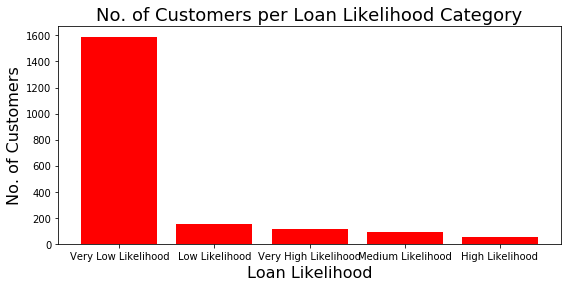

In [203]:
new_df = pd.DataFrame(df_loan_likelihoods['Likelihood Category'].value_counts())

# Set the corresponding positions on the y-axis
y_pos = range(len(new_df.index.values))

# Create a new figure & set the canvas size
plt.figure(figsize=(9,4))

# Plot the bar chart
bars = plt.bar(y_pos, new_df['Likelihood Category'], align='center', color='red')
plt.xticks(y_pos, new_df.index.values)
plt.xlabel("Loan Likelihood", fontsize=16)
plt.ylabel("No. of Customers", fontsize=16)
plt.title("No. of Customers per Loan Likelihood Category", fontsize=18)
plt.savefig(EDA_PARENT_DIR + 'Customers_per_LoanLikelihoodCategory.png')